In [61]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import KFold

# Chargement des données

In [24]:
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')

X['maille_safran'] = X['maille_safran'].astype(str)
Y['Mailles'] = Y['Mailles'].astype(str)
Y.rename(columns={'Mailles': 'maille_safran', 'Année': 'Année'}, inplace=True)

X['maille_safran'] = X['maille_safran'].astype(int)
Y['maille_safran'] = Y['maille_safran'].astype(float).astype(int)

data = pd.merge(X, Y, on=['maille_safran', 'Année'], how='inner')

In [25]:
# Problèmes avec les données de 2021 qui n'était pas binaires
data.loc[data['Feu en été'] > 1, 'Feu en été'] = 1

In [26]:
Xt = data.drop(columns=['Feu en été', 'maille_safran', 'Année'])  # Exclure la colonne 'résultat' de X
y = data['Feu en été']

In [30]:
# Important, voir le nombre de 1 et de 0, pour voir la répartition des classes
nb_1 = Y['Feu en été'].sum()
nb_0 = 2856 - nb_1
# Affichage du résultat
print("Nombre de 1:", nb_1)
print("Nombre de 0:", nb_0)

# Ratio des deux
pour_1 = nb_1 / 2856
pour_0 = nb_0 / 2856

print("Proportion de 1 :", pour_1)
print("Proportion de 0 :", pour_0)

Nombre de 1: 1509
Nombre de 0: 1347
Proportion de 1 : 0.5283613445378151
Proportion de 0 : 0.47163865546218486


# 1 - GLM avec Logit

In [44]:
# Ajouter une constante à la matrice X pour l'intercept
Xt = sm.add_constant(Xt)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=42)

# Initialiser le modèle GLM (par exemple, une régression logistique)
model_glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())

# Ajuster le modèle aux données
result = model_glm.fit()

# Faire des prédictions sur l'ensemble de test
y_pred_glm = result.predict(X_test)
y_pred_glm = (y_pred_glm > 0.5).astype(int)  # Convertir les probabilités en prédictions binaires

# Calculer l'accuracy
accuracy_glm = accuracy_score(y_test, y_pred_glm)
print("Accuracy GLM:", accuracy_glm)

# Calculer le F1-score
f1_glm = f1_score(y_test, y_pred_glm)
print("F1-score GLM:", f1_glm)

# Afficher un résumé des résultats
print(result.summary())

Accuracy GLM: 0.7224489795918367
F1-score GLM: 0.7702702702702703
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Feu en été   No. Observations:                 1958
Model:                            GLM   Df Residuals:                     1866
Model Family:                Binomial   Df Model:                           91
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -992.90
Date:                Tue, 30 Apr 2024   Deviance:                       1985.8
Time:                        08:16:35   Pearson chi2:                 2.29e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2885
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

# 2 - Régression linéaire pénalisée Lasso et Ridge

### a. Lasso

In [50]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=42)

# Initialiser le modèle de régression logistique pénalisée Lasso
lasso_model = LogisticRegression(penalty='l1', solver='liblinear')

# Entraîner le modèle sur l'ensemble d'entraînement
lasso_model.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred_lasso = lasso_model.predict(X_test)

y_prob_lasso = lasso_model.predict_proba(X_test)[:, 1]

# Calculer l'accuracy
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
print("Accuracy Lasso Logistic Regression:", accuracy_lasso)

# Calculer le F1 score
f1_lasso = f1_score(y_test, y_pred_lasso)
print("F1-score Lasso Logistic Regression:", f1_lasso)

Accuracy Lasso Logistic Regression: 0.7285714285714285
F1-score Lasso Logistic Regression: 0.7757166947723441


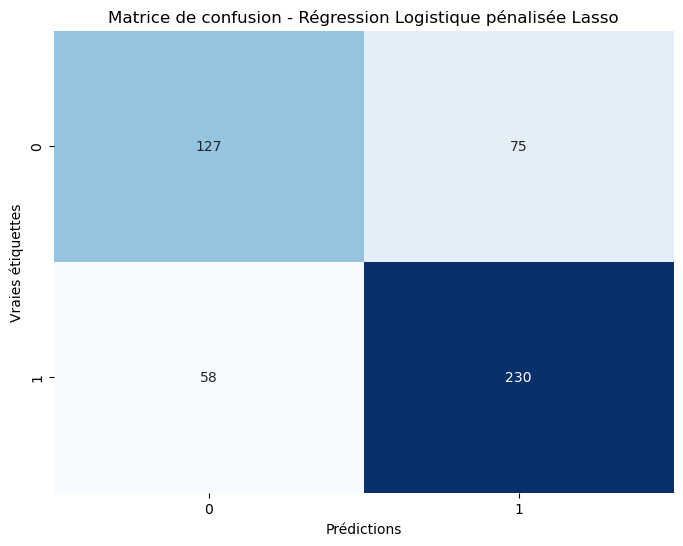

In [37]:
# Afficher la matrice de confusion
cm_lasso = confusion_matrix(y_test, y_pred_lasso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lasso, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion - Régression Logistique pénalisée Lasso')
plt.show()

### b. Ridge

In [51]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=42)

# Initialiser le modèle de régression logistique pénalisée Ridge
ridge_model = LogisticRegression(penalty='l2', solver='liblinear')

# Entraîner le modèle sur l'ensemble d'entraînement
ridge_model.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred_ridge = ridge_model.predict(X_test)

y_prob_ridge = ridge_model.predict_proba(X_test)[:, 1]

# Calculer l'accuracy
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
print("Accuracy Ridge Logistic Regression:", accuracy_ridge)

# Calculer le F1 score
f1_ridge = f1_score(y_test, y_pred_ridge)
print("F1-score Ridge Logistic Regression:", f1_ridge)

Accuracy Ridge Logistic Regression: 0.7244897959183674
F1-score Ridge Logistic Regression: 0.7715736040609137


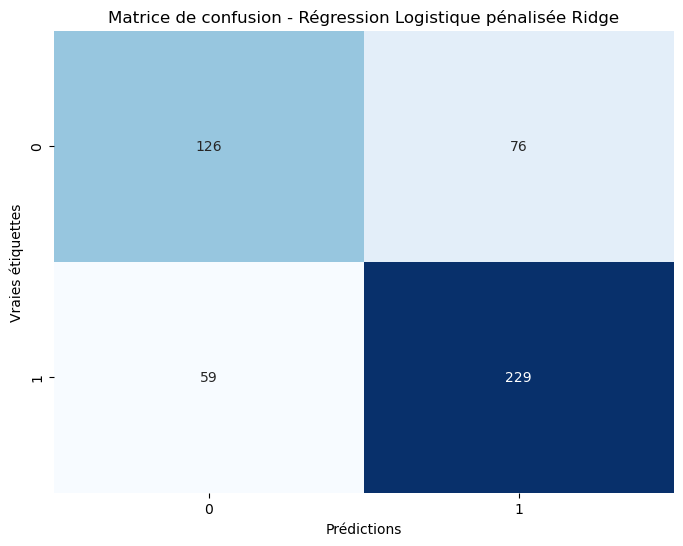

In [40]:
# Afficher la matrice de confusion
cm_ridge = confusion_matrix(y_test, y_pred_ridge)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ridge, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion - Régression Logistique pénalisée Ridge')
plt.show()

# 3 - Random Forest

In [53]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=42)

# Initialiser le modèle Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
model_rf.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = model_rf.predict(X_test)

y_prob_random_forest = model_rf.predict_proba(X_test)[:, 1]

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sur l'ensemble de test:", accuracy)

# Calculer le F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score Random Forest:", f1)

Accuracy sur l'ensemble de test: 0.8061224489795918
F1-score Random Forest: 0.8063294525523396


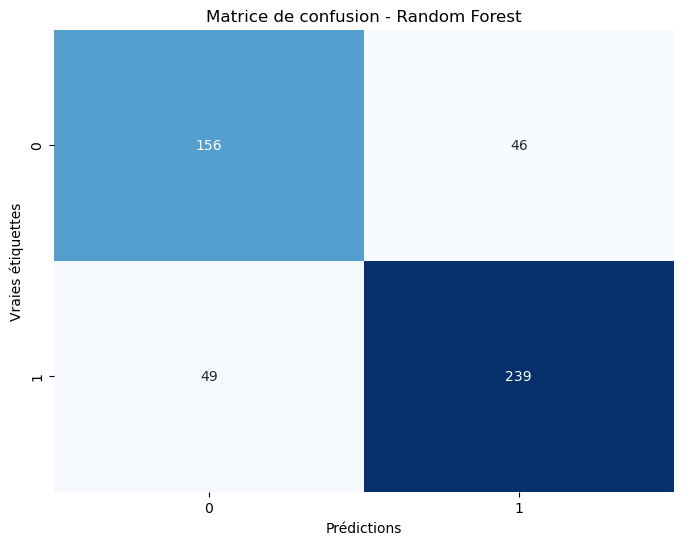

In [46]:
# Afficher la matrice de confusion
cm_random_forest = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_random_forest, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion - Random Forest')
plt.show()

# 4 - ADABOOST

In [52]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=42)

# Initialiser le modèle AdaBoost
adaboost_model = AdaBoostClassifier()

# Entraîner le modèle sur l'ensemble d'entraînement
adaboost_model.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred_adaboost = adaboost_model.predict(X_test)

y_prob_adaboost = adaboost_model.predict_proba(X_test)[:, 1]

# Calculer l'accuracy
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
print("Accuracy AdaBoost:", accuracy_adaboost)

# Calculer le F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score ADABOOST:", f1)

/opt/mamba/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy AdaBoost: 0.726530612244898
F1-score ADABOOST: 0.8063294525523396


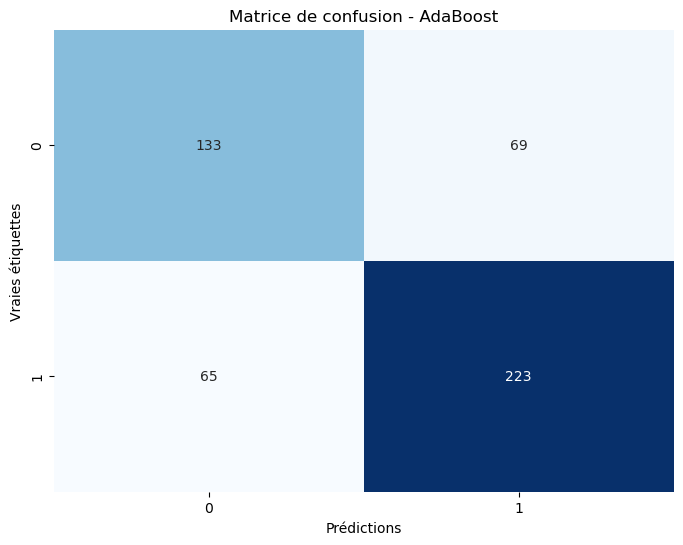

In [35]:
# Afficher la matrice de confusion
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adaboost, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion - AdaBoost')
plt.show()

# Comparaison des modèles

## A. Courbes ROC

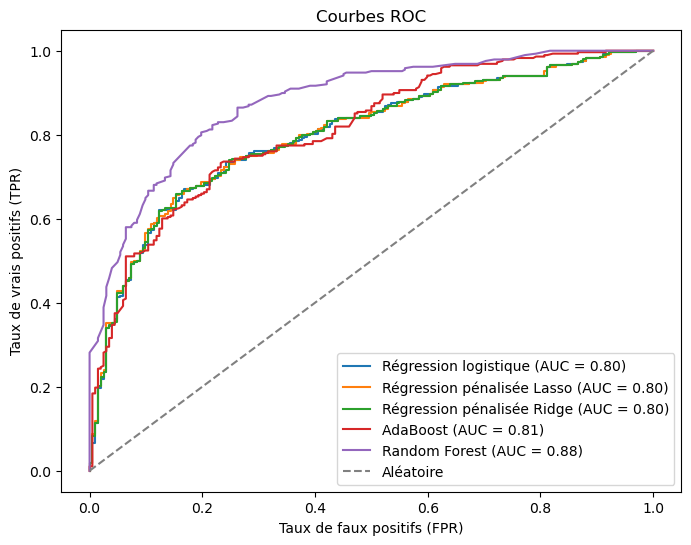

In [56]:
# Calculer les probabilités prédites pour le modèle GLM
y_prob_glm = result.predict(X_test)

# Calculer les taux de faux positifs (FPR) et les taux de vrais positifs (TPR) pour le modèle GLM
fpr_glm, tpr_glm, _ = roc_curve(y_test, y_prob_glm)

# Calculer l'aire sous la courbe ROC (AUC) pour le modèle GLM
roc_auc_glm = auc(fpr_glm, tpr_glm)

# Calculer les taux de faux positifs (FPR) et les taux de vrais positifs (TPR) pour chaque modèle
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_prob_lasso)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_prob_ridge)
fpr_adaboost, tpr_adaboost, _ = roc_curve(y_test, y_prob_adaboost)
fpr_random_forest, tpr_random_forest, _ = roc_curve(y_test, y_prob_random_forest)

# Calculer l'aire sous la courbe ROC (AUC) pour chaque modèle
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)
roc_auc_random_forest = auc(fpr_random_forest, tpr_random_forest)

# Tracer les courbes ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_glm, tpr_glm, label=f'Régression logistique (AUC = {roc_auc_glm:.2f})')
plt.plot(fpr_lasso, tpr_lasso, label=f'Régression pénalisée Lasso (AUC = {roc_auc_lasso:.2f})')
plt.plot(fpr_ridge, tpr_ridge, label=f'Régression pénalisée Ridge (AUC = {roc_auc_ridge:.2f})')
plt.plot(fpr_adaboost, tpr_adaboost, label=f'AdaBoost (AUC = {roc_auc_adaboost:.2f})')
plt.plot(fpr_random_forest, tpr_random_forest, label=f'Random Forest (AUC = {roc_auc_random_forest:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbes ROC')
plt.legend(loc='lower right')
plt.show()

## B. Validation croisée

In [60]:
# Liste des modèles
models = [
    ('Régression pénalisée Lasso', lasso_model),
    ('Régression pénalisée Ridge', ridge_model),
    ('AdaBoost', adaboost_model),
    ('Random Forest', model_rf)
]

# Effectuer la validation croisée pour chaque modèle
for name, model in models:
    cv_scores = cross_val_score(model, Xt, y, cv=5, scoring='accuracy')
    print(f"{name}: Moyenne des scores de validation croisée - {np.mean(cv_scores):.2f}")

Régression pénalisée Lasso: Moyenne des scores de validation croisée - 0.36
Régression pénalisée Ridge: Moyenne des scores de validation croisée - 0.35


/opt/mamba/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/mamba/lib/python3.1

AdaBoost: Moyenne des scores de validation croisée - 0.40
Random Forest: Moyenne des scores de validation croisée - 0.42


Ne fonctionne pas pour le moment, éventuellement à reprendre mais pénible

In [62]:
# Définir le nombre de folds pour la validation croisée
n_splits = 5
kf = KFold(n_splits=n_splits)

# Liste pour stocker les scores de validation croisée
cv_scores = []

# Effectuer la validation croisée pour chaque fold
for train_index, test_index in kf.split(Xt):
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test = Xt[train_index], Xt[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialiser le modèle GLM
    model_glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())

    # Ajuster le modèle GLM aux données
    result = model_glm.fit()

    # Prédire sur l'ensemble de test
    y_pred = result.predict(X_test)
    
    # Calculer l'exactitude (accuracy)
    accuracy = np.mean((y_pred >= 0.5) == y_test)
    
    # Ajouter le score à la liste
    cv_scores.append(accuracy)

# Afficher les scores de validation croisée
print("Scores de validation croisée:", cv_scores)
print("Moyenne des scores de validation croisée:", np.mean(cv_scores))


KeyError: "None of [Index([ 490,  491,  492,  493,  494,  495,  496,  497,  498,  499,\n       ...\n       2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447],\n      dtype='int64', length=1958)] are in the [columns]"

## C. Conclusion et interprétation

Le modèle Random Forest semble être le plus performant dans notre cas : meilleure accuracy, meilleur F1 score, plus grande aire en dessous de la courbe ROC et score le plus élevé en validation croisée. On pourrait donc raisonnablement choisir ce modèle.

# Tests préliminaires

## 1- Modèle GLM

In [38]:
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')

X['maille_safran'] = X['maille_safran'].astype(str)
Y['Mailles'] = Y['Mailles'].astype(str)
Y.rename(columns={'Mailles': 'maille_safran', 'Année': 'Année'}, inplace=True)

X['maille_safran'] = X['maille_safran'].astype(int)
Y['maille_safran'] = Y['maille_safran'].astype(float).astype(int)

data = pd.merge(X, Y, on=['maille_safran', 'Année'], how='inner')
data['IFM_moy'] = data.iloc[:, 2:32].mean(axis=1)  #On regresse sur ça mais je capte pas bien ce que c'est


In [19]:
# Modèle GLM avec lien logit
model = smf.glm(formula='Q("Feu en été") ~ IFM_moy', data=data, family=sm.families.Binomial())
result = model.fit()

print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:        Q("Feu en été")   No. Observations:                 2448
Model:                            GLM   Df Residuals:                     2446
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 18 Apr 2024   Deviance:                       4991.0
Time:                        16:28:05   Pearson chi2:                 2.68e+03
No. Iterations:                     5   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5263      0.087      6.030      0.0

/opt/mamba/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1891: RuntimeWarning: invalid value encountered in scalar subtract
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


## 2 - Train/Test

## a. Regression Logistique

En fait, nos classes sont plutôt égales!

In [55]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=42)

# Initialiser le modèle de régression logistique
model = LogisticRegression()

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer les performances du modèle en utilisant l'exactitude (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculer le F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score Regression Logistique:", f1)

Accuracy: 0.6959183673469388
F1-score Regression Logistique: 0.6904846512248648


/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy  0,7 environ

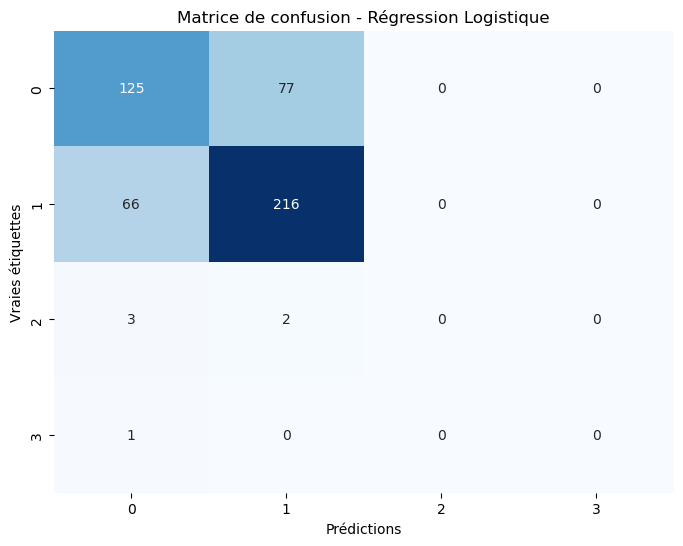

In [56]:
# Matrice de confusion pour le modèle Random Forest
cm_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion - Régression Logistique')
plt.show()

## b. Arbre de décision

In [23]:
Xt = data.drop(columns=['Feu en été'])  # Exclure la colonne 'résultat' de X
y = data['Feu en été']

In [52]:
# Diviser les données en ensembles d'entraînement et de test (si ce n'est pas déjà fait)
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=42)

# Initialiser le modèle d'arbre de décision
model = DecisionTreeClassifier()

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer les performances du modèle en utilisant l'exactitude (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculer le F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score Arbre de décision:", f1)

Accuracy: 0.7673469387755102
F1-score Arbre de décision: 0.767019535086762


Accuracy  0,76 environ